In [1]:
!pip install -U setuptools wheel
!pip install -U "mxnet_cu110<2.0.0"
!pip install autogluon==0.3.1

     |████████████████████████████████| 1.1 MB 598 kB/s            
  Attempting uninstall: wheel
    Found existing installation: wheel 0.37.0
    Uninstalling wheel-0.37.0:
      Successfully uninstalled wheel-0.37.0
  Attempting uninstall: setuptools
    Found existing installation: setuptools 59.5.0
    Uninstalling setuptools-59.5.0:
      Successfully uninstalled setuptools-59.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
beatrix-jupyterlab 3.1.6 requires google-cloud-bigquery-storage, which is not installed.
thinc 8.0.13 requires typing-extensions<4.0.0.0,>=3.7.4.1; python_version < "3.8", but you have typing-extensions

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from numpy.random import RandomState
from imblearn.over_sampling import SMOTENC


In [4]:
from autogluon.tabular import TabularPredictor

directory = '../input'
label = 'label'
eval_metric = 'accuracy' 
save_path = './AutoGluonModels/'

# Train

In [5]:
df = pd.read_csv(f"{directory}/msbd5001-spring-2022/train.csv")
df.head()

,id,MO HLADR+ MFI (cells/ul),Neu CD64+MFI (cells/ul),CD3+T (cells/ul),CD8+T (cells/ul),CD4+T (cells/ul),NK (cells/ul),CD19+ (cells/ul),CD45+ (cells/ul),Age,Sex 0M1F,Mono CD64+MFI (cells/ul),label
0,0,3556.0,2489.0,265.19,77.53,176.55,0.00,4.20,307.91,52,0,7515.0,1
1,1,1906.0,134.0,1442.61,551.90,876.07,112.10,168.15,1735.48,20,1,1756.0,0
2,2,1586.0,71.0,1332.74,684.20,655.26,244.95,216.52,1820.04,28,1,1311.0,0
3,3,683.0,94.0,419.23,255.80,162.17,72.05,44.68,538.22,55,1,1443.0,0
4,4,1032.0,71.0,1102.72,480.27,625.30,188.78,130.77,1427.97,28,1,1542.0,0


In [6]:
df.describe()

,id,MO HLADR+ MFI (cells/ul),Neu CD64+MFI (cells/ul),CD3+T (cells/ul),CD8+T (cells/ul),CD4+T (cells/ul),NK (cells/ul),CD19+ (cells/ul),CD45+ (cells/ul),Age,Sex 0M1F,Mono CD64+MFI (cells/ul),label
count,87.000000,86.000000,86.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,86.000000,87.000000
mean,43.000000,1264.244186,290.383721,982.570115,479.340920,494.904023,212.732874,118.780920,1325.096437,40.218391,0.482759,2066.534884,0.333333
std,25.258662,765.452376,490.283499,617.332545,344.326452,311.836604,173.553264,96.218344,791.602538,10.461919,0.502599,1198.401364,0.474137
min,0.000000,112.000000,30.000000,74.400000,36.610000,39.590000,0.000000,4.200000,209.250000,19.000000,0.000000,72.000000,0.000000
25%,21.500000,685.500000,77.500000,549.390000,237.920000,272.745000,78.815000,52.425000,780.615000,33.000000,0.000000,1461.250000,0.000000
50%,43.000000,1108.500000,124.500000,871.710000,423.270000,459.720000,188.780000,89.790000,1179.270000,41.000000,0.000000,1757.500000,0.000000
75%,64.500000,1602.250000,244.500000,1268.085000,624.450000,624.360000,262.845000,155.450000,1617.725000,49.500000,1.000000,2238.250000,1.000000
max,86.000000,4145.000000,3124.000000,3791.230000,2548.100000,1517.810000,878.040000,485.860000,4757.280000,60.000000,1.000000,7515.000000,1.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        87 non-null     int64  
 1   MO HLADR+ MFI (cells/ul)  86 non-null     float64
 2   Neu CD64+MFI (cells/ul)   86 non-null     float64
 3   CD3+T (cells/ul)          87 non-null     float64
 4   CD8+T (cells/ul)          87 non-null     float64
 5   CD4+T (cells/ul)          87 non-null     float64
 6   NK (cells/ul)             87 non-null     float64
 7   CD19+ (cells/ul)          87 non-null     float64
 8   CD45+ (cells/ul)          87 non-null     float64
 9   Age                       87 non-null     int64  
 10  Sex 0M1F                  87 non-null     int64  
 11  Mono CD64+MFI (cells/ul)  86 non-null     float64
 12  label                     87 non-null     int64  
dtypes: float64(9), int64(4)
memory usage: 9.0 KB


In [8]:
df.columns

Index(['id', 'MO HLADR+ MFI (cells/ul)', 'Neu CD64+MFI (cells/ul)',
       'CD3+T (cells/ul)', 'CD8+T (cells/ul)', 'CD4+T (cells/ul)',
       'NK (cells/ul)', 'CD19+ (cells/ul)', 'CD45+ (cells/ul)', 'Age',
       'Sex 0M1F', 'Mono CD64+MFI (cells/ul)', 'label'],
      dtype='object')

In [9]:
train_data = df.copy()

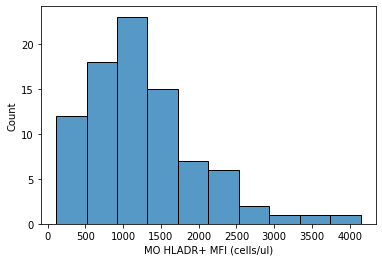

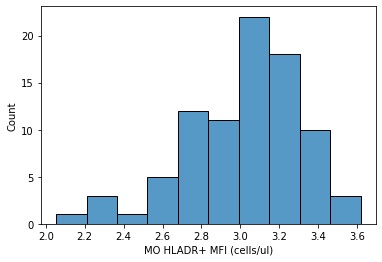

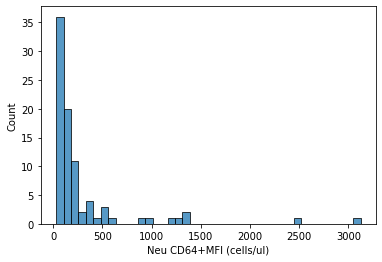

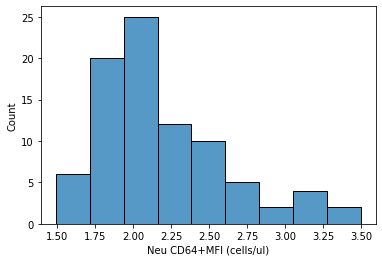

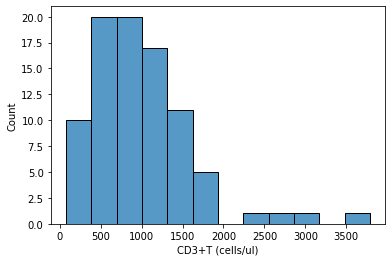

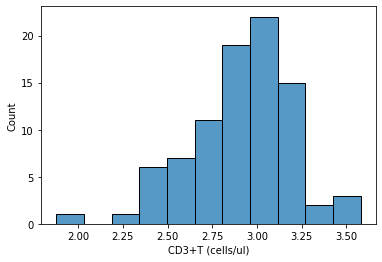

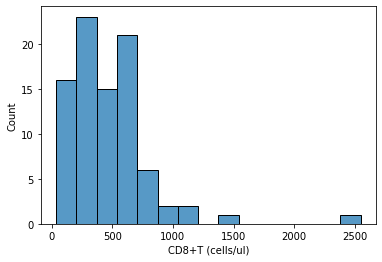

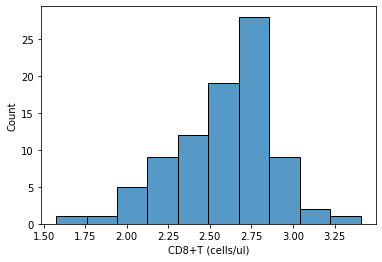

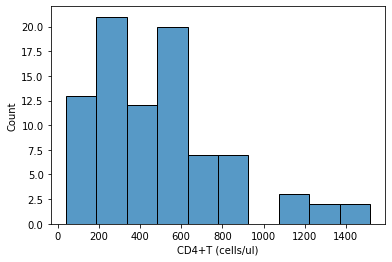

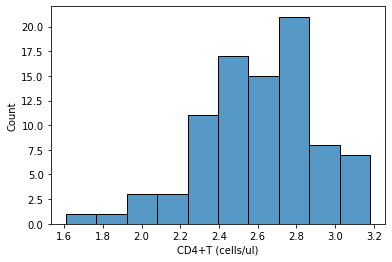

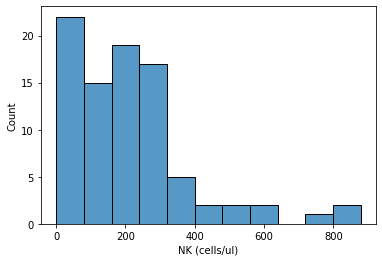

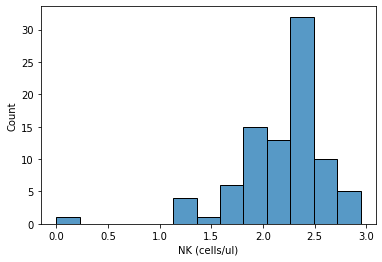

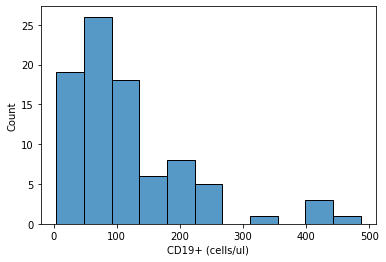

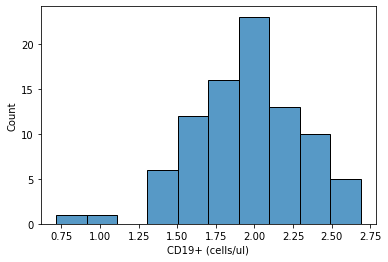

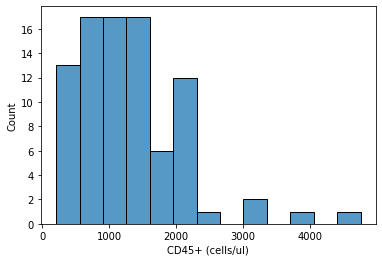

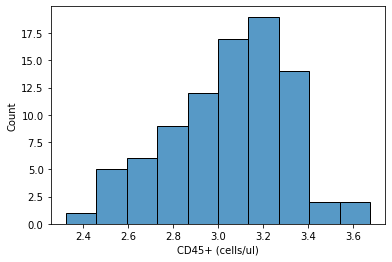

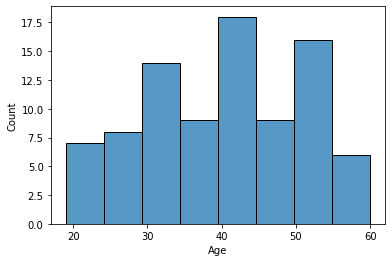

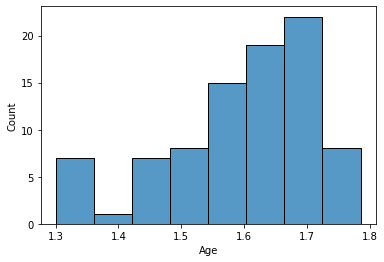

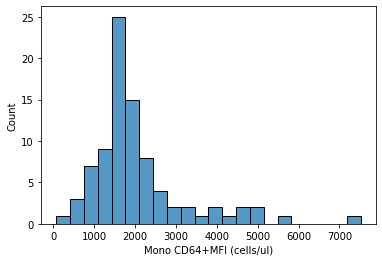

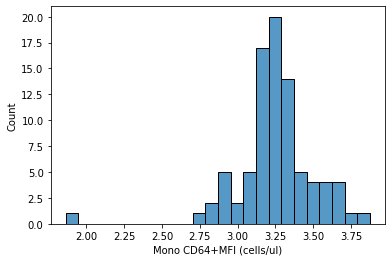

In [10]:
for col in df.columns:
    if col not in ['id', 'Sex 0M1F', 'label']:
        sns.histplot(df[col])
        plt.show()
        sns.histplot(np.log10(df[col]+1))
        plt.show()
        train_data[col] = np.log10(df[col]+1)

In [11]:
train_data = train_data.drop('id', axis=1)
train_data.describe()

,MO HLADR+ MFI (cells/ul),Neu CD64+MFI (cells/ul),CD3+T (cells/ul),CD8+T (cells/ul),CD4+T (cells/ul),NK (cells/ul),CD19+ (cells/ul),CD45+ (cells/ul),Age,Sex 0M1F,Mono CD64+MFI (cells/ul),label
count,86.000000,86.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,86.000000,87.000000
mean,3.015424,2.193378,2.911927,2.587624,2.606049,2.168901,1.950233,3.047946,1.599434,0.482759,3.250248,0.333333
std,0.298836,0.422495,0.280203,0.299521,0.297849,0.447699,0.353347,0.265457,0.121621,0.502599,0.258737,0.474137
min,2.053078,1.491362,1.877371,1.575303,1.608419,0.000000,0.716003,2.322736,1.301030,0.000000,1.863323,0.000000
25%,2.836632,1.894843,2.740665,2.378236,2.437310,1.902022,1.727727,2.892988,1.531479,0.000000,3.164922,0.000000
50%,3.045115,2.098640,2.940870,2.627642,2.663437,2.278250,1.958038,3.071981,1.623249,0.000000,3.245142,0.000000
75%,3.204996,2.390049,3.103365,2.796192,2.796130,2.421298,2.194374,3.209173,1.703270,1.000000,3.350090,1.000000
max,3.617629,3.494850,3.578895,3.406387,3.181503,2.944009,2.687404,3.677450,1.785330,1.000000,3.875987,1.000000


In [12]:
# df = df.dropna()

In [13]:
train_data.iloc[:,:-1]

,MO HLADR+ MFI (cells/ul),Neu CD64+MFI (cells/ul),CD3+T (cells/ul),CD8+T (cells/ul),CD4+T (cells/ul),NK (cells/ul),CD19+ (cells/ul),CD45+ (cells/ul),Age,Sex 0M1F,Mono CD64+MFI (cells/ul)
0,3.551084,3.396199,2.425192,1.895036,2.249321,0.000000,0.716003,2.489832,1.724276,0,3.875987
1,3.280351,2.130334,3.159450,2.742647,2.943034,2.053463,2.228272,3.239670,1.322219,1,3.244772
2,3.200577,1.857332,3.125071,2.835817,2.817076,2.390847,2.337499,3.260319,1.462398,1,3.117934
3,2.835056,1.977724,2.623487,2.409595,2.212640,1.863620,1.659726,2.731766,1.748188,1,3.159567
4,3.014100,1.857332,3.042859,2.682389,2.796782,2.278250,2.119817,3.155023,1.462398,1,3.188366
...,...,...,...,...,...,...,...,...,...,...,...
82,2.797268,1.838849,3.248603,2.824770,3.048628,2.557760,2.078602,3.363202,1.633468,1,3.182415
83,3.092721,1.857332,3.130183,2.632548,2.966466,2.082857,1.696094,3.183492,1.755875,0,3.129045
84,2.802774,3.001301,3.114277,2.747412,2.860338,1.832509,2.025306,3.171802,1.544068,0,3.466423
85,2.053078,2.946943,2.974894,2.579200,2.754394,2.071035,1.516006,3.043594,1.531479,1,3.371622


In [14]:
# train_data = train_data.dropna()
# print(f'Original dataset samples per class {Counter(train_data[label])}')
# sm = SMOTENC(random_state=42, categorical_features=[9])
# X_res, y_res = sm.fit_resample(train_data.iloc[:,:-1], train_data[label])
# print(f'Resampled dataset samples per class {Counter(y_res)}')
# y_res = y_res.values.reshape(-1,1)
# X_res = X_res.values

In [15]:
# X_res.shape, y_res.shape

In [16]:
# X_res[:, 9]

In [17]:
# temp = np.concatenate([X_res, y_res], axis=1)
# temp = pd.DataFrame(temp, columns=train_data.columns)
# temp

In [18]:
predictor = TabularPredictor(label=label, eval_metric=eval_metric, path=save_path).fit(
    train_data, presets='best_quality', time_limit=3600*10
)
results = predictor.fit_summary()

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a f

*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0       WeightedEnsemble_L2   0.942529       0.502312  39.146899                0.000537           0.287611            2       True         14
1           CatBoost_BAG_L1   0.931034       0.180217  17.094871                0.180217          17.094871            1       True          7
2   RandomForestGini_BAG_L1   0.919540       0.164642   0.747534                0.164642           0.747534            1       True          5
3      LightGBMLarge_BAG_L1   0.919540       0.249606  25.444170                0.249606          25.444170            1       True         13
4         LightGBMXT_BAG_L1   0.908046       0.197863  20.360515                0.197863          20.360515            1       True          3
5    NeuralNetFastAI_BAG_L1   0.908046       1.379272  69.992044                

# Test

In [19]:
import pickle

with open('predictor.pickle', 'wb') as handle:
    pickle.dump(predictor, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('predictor.pickle', 'rb') as handle:
    model = pickle.load(handle)

In [20]:
test_df = pd.read_csv(f"{directory}/msbd5001-spring-2022/test.csv")

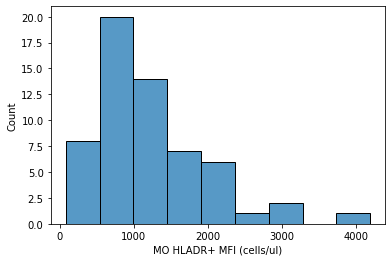

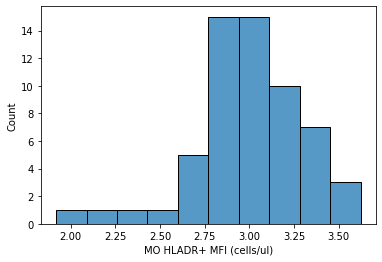

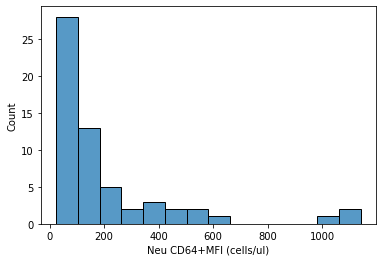

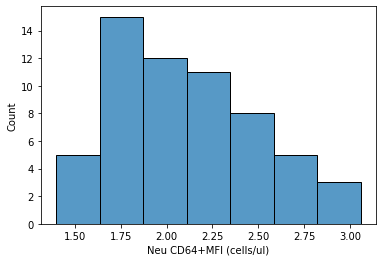

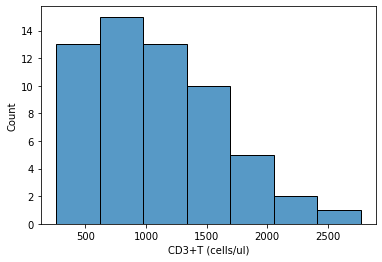

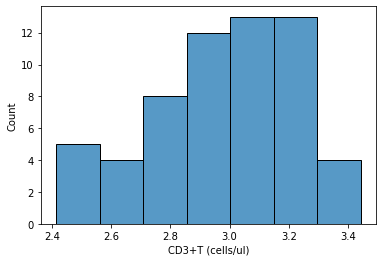

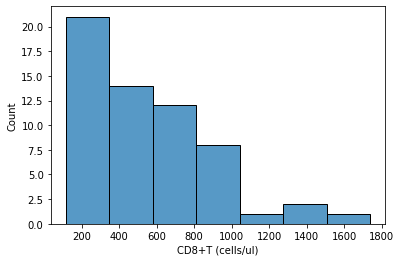

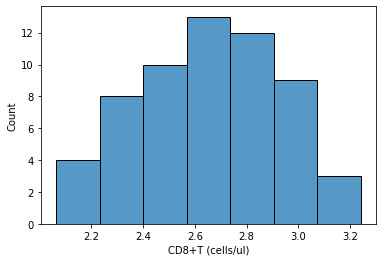

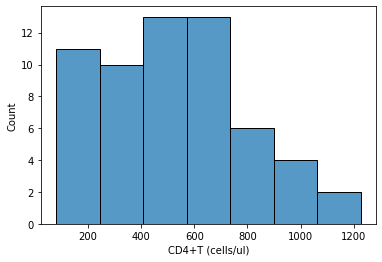

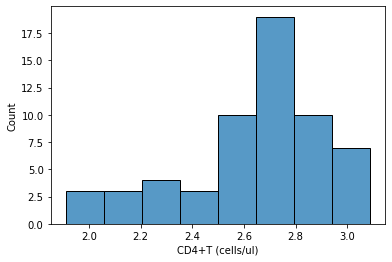

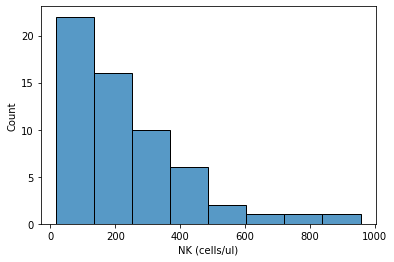

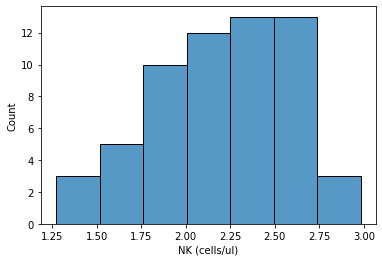

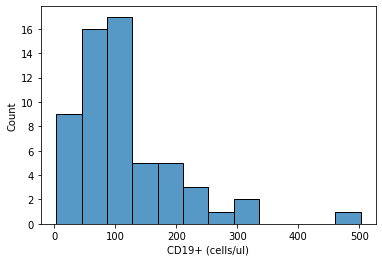

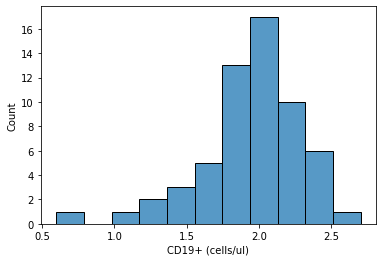

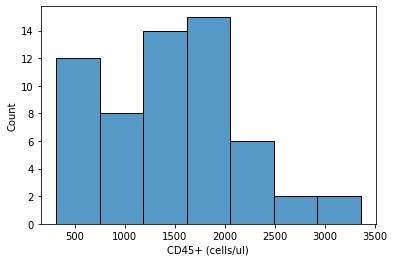

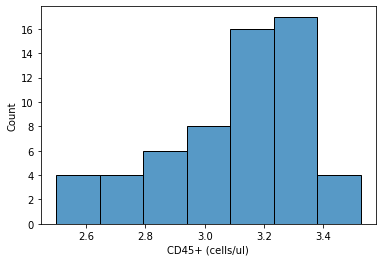

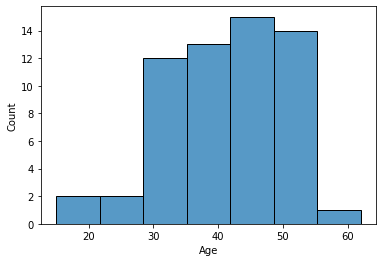

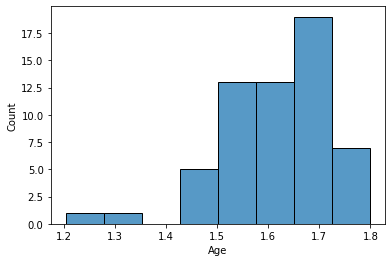

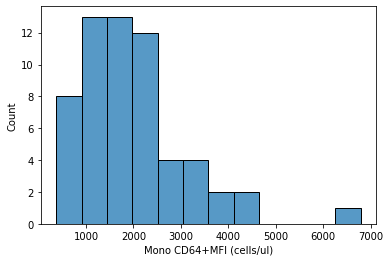

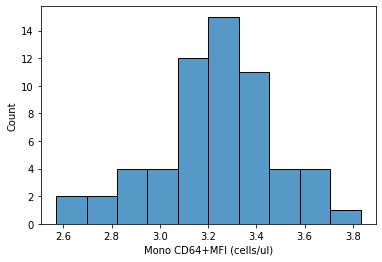

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    1
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    1
21    1
22    0
23    0
24    0
25    1
26    0
27    0
28    1
29    0
30    1
31    1
32    0
33    1
34    0
35    0
36    0
37    1
38    1
39    0
40    1
41    0
42    0
43    0
44    0
45    0
46    0
47    1
48    0
49    0
50    0
51    0
52    0
53    0
54    0
55    0
56    0
57    0
58    1
Name: label, dtype: int64

In [21]:
test_data = test_df.copy()
test_data = test_data.drop('id', axis=1)
for col in test_df.columns:
    if col not in ['id', 'Sex 0M1F', 'label']:
        sns.histplot(test_df[col])
        plt.show()
        sns.histplot(np.log10(test_df[col]+1))
        plt.show()
        test_data[col] = np.log10(test_df[col]+1)
y_pred = model.predict(test_data)
y_pred

In [22]:
submission = pd.read_csv(f"{directory}/msbd5001-spring-2022/sample_submission.csv")
submission[label] = y_pred
submission.head()

,id,label
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [23]:
sum(y_pred)

13

In [24]:
submission.to_csv('./submission.csv', index=False)

In [25]:
# !zip -r agl.zip ./AutoGluonModels